In [2]:
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u
from astropy.modeling.models import BlackBody as bb

In [3]:
m_min = 0.1
m_max = 100
T_sun = 5775
alfa = -2.35

wav = np.arange(1200, 20000)*u.AA

def mass_to_time(mass):
    return (mass ** (-2.5))*10  #Gyrs

def salpeter(mass):
    return mass**(alfa)

def mass_to_temperature(mass):
    return mass**0.5

def mass_to_luminosity(mass):
    return mass**3.5

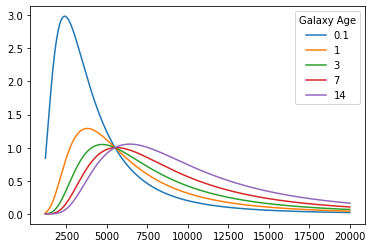

In [4]:
n_bins = 10000
star_pop = np.linspace(m_min, m_max, n_bins)
delta_m = (m_max - m_min)/n_bins

ages = [0.1 , 1, 3, 7, 14] #Guess on galaxy age in Gyrs -> G1, G2, G3

for s in ages:
    spectrum_normalized = 0
    for i in range(len(star_pop)):
        mass_time = mass_to_time(star_pop[i])
        if(mass_time > s):
            temp = mass_to_temperature(star_pop[i]) * T_sun
            model = bb(temperature=temp*u.K, scale= 1 * u.erg/(u.cm ** 2 * u.AA * u.s * u.sr))
            spectrum = model(wav)/model.bolometric_flux.value
            luminosity_norm = mass_to_luminosity(star_pop[i])
            imf_norm = salpeter(star_pop[i])
            spectrum_normalized += (spectrum * luminosity_norm * imf_norm) / delta_m

    plt.plot(wav, spectrum_normalized/spectrum_normalized[wav==5500*u.AA], label= s )


plt.legend(title = 'Galaxy Age')
plt.show();

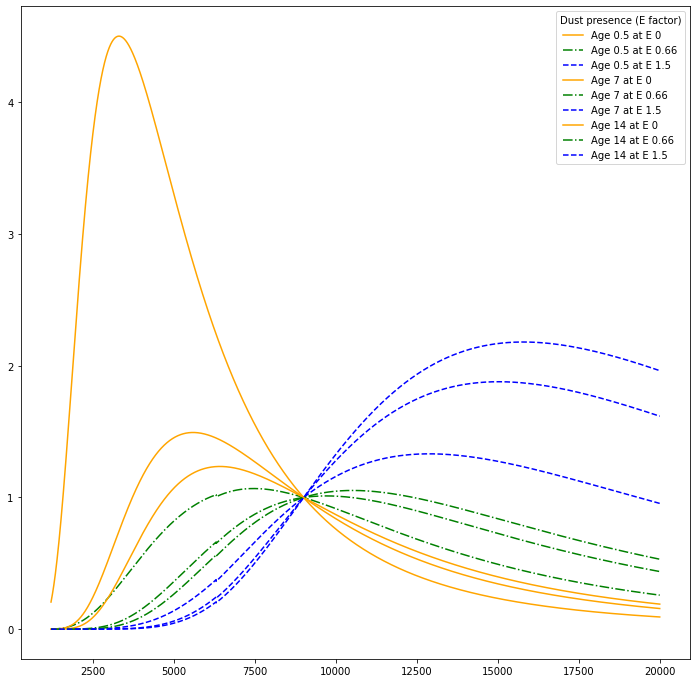

In [5]:
#Color Excess -> Dust presence investigation 

R_v = 4.05

def dust_abs(E, wave):
    dimless = wave.value/10000      #Angstrom --> Dimensionless Micron conversion, otherwise the equations for k don't make sense!!

    k_i = []
    for lambd in dimless:
        if(lambd >= 0.12 and lambd <= 0.63):
            k = 2.659 * (-2.156 + 1.509/lambd - 0.198/(lambd**2) + 0.011/(lambd**3)) + R_v
            k_i.append(k)
        elif(lambd > 0.63 and lambd <= 2.20):
            k = 2.659 * (-1.857 + 1.040/lambd) + R_v
            k_i.append(k)

    k_i = np.array(k_i)
    a_lambda = k_i * E

    #Calzetti Empyrical Law
    attenuation = 10 ** (-0.4 * a_lambda)
    
    return attenuation

n_bins = 10000
star_pop = np.linspace(m_min, m_max, n_bins)
delta_m = (m_max - m_min)/n_bins

#ages = [0.1 , 1, 3, 7, 14] #Guess on galaxy age in Gyrs -> G1, G2, G3
ages = [0.5, 7, 14]
colors = ['orange', 'green', 'blue']
dustness = [0, 0.66, 1.5]
lines = ['-', '-.', '--']

fig, ax = plt.subplots(figsize=(12, 12))

for s in ages:
    spectrum_obs = 0
    spectrum_normalized = 0
    for i in range(len(star_pop)):
        mass_time = mass_to_time(star_pop[i])                                                       #If time <= galaxy_age the star would have died long ago!!
        if(mass_time > s):
            temp = mass_to_temperature(star_pop[i]) * T_sun                                         #Mass conversion
            model = bb(temperature=temp*u.K, scale= 1 * u.erg/(u.cm ** 2 * u.AA * u.s * u.sr))      #Building BB spectrum
            spectrum = model(wav)/model.bolometric_flux.value                                       #Bolometric normalization
            luminosity_norm = mass_to_luminosity(star_pop[i])                                       #Luminosity normalization
            imf_norm = salpeter(star_pop[i])                                                        #Salpeter Initial Mass Function (IMF) for number density
            spectrum_normalized += (spectrum * luminosity_norm * imf_norm) / delta_m                #Final flux spectrum

    for j, ss, sss in zip(dustness, colors, lines):                                                 #Scanning at different dust attenuation
        newlabel = 'Age ' + str(s) + ' at E ' + str(j)
        spectrum_obs = spectrum_normalized * dust_abs(j, wav)
        plt.plot(wav, spectrum_obs/spectrum_obs[wav == 9000*u.AA], label=newlabel, c=ss, ls=sss)    #To renormalize divide y by ->  /spectrum_obs[wav == 9000*u.AA]

plt.legend(title = 'Dust presence (E factor)')
plt.show();